In [54]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
from shapely.geometry import mapping
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import warnings
warnings.filterwarnings("ignore")

#### The netcdf file imported using xarray package

In [3]:
ds = xr.open_dataset(
    '/Users/arunraj/Desktop/Omdena/data/netcdf/UCSB_CHIRPS_rainfall_data.nc')
ds
ds.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:               (latitude: 119, longitude: 94, time: 15583)
Coordinates:
  * latitude              (latitude) float64 20.72 20.77 20.82 ... 26.57 26.62
  * longitude             (longitude) float64 88.03 88.08 88.13 ... 92.63 92.68
  * time                  (time) datetime64[ns] 1981-01-01 ... 2023-08-31
    spatial_ref           int64 0
Data variables:
    precipitation_amount  (time, latitude, longitude) float32 ...

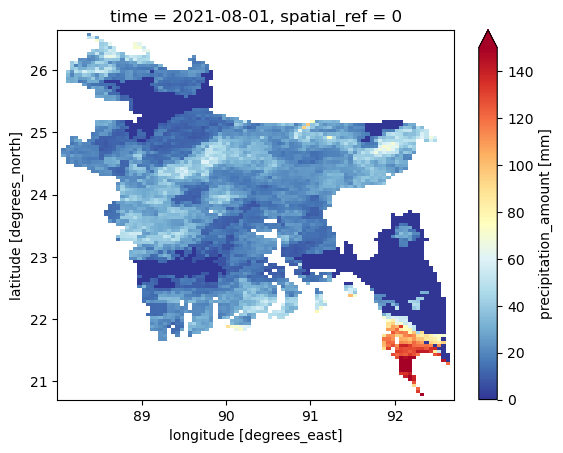

In [15]:
# displays the rainfall for a day

ds.precipitation_amount.sel(
    time=('2021-08-01')).plot(vmin=0, vmax=150, cmap='RdYlBu_r')

In [16]:

# importing the district shape files to extract data for each districts

districts = gpd.read_file(
    '/Users/arunraj/Desktop/Omdena/data/bangladesh_districts/bangladesh_districts.shp')
districts.head(1)

,fid,GEO_CODE,DIVISION_C,DIVISION_N,DISTRICT_C,DISTRICT_N,TOTAL_DIVC,TOTAL_DCC,TOTAL_UCC,TOTAL_ZCC,...,CITY_NAME,UPAZILA_CO,UPAZILA_NA,MUNICIPALI,MUNICIPA_1,UNION_CODE,UNION_NAME,MAUZA_CODE,TOTAL_NRB,geometry
0,1.0,2003,20,Chattogram,03,Bandarban,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5360.0,"POLYGON ((92.19397 22.34893, 92.19619 22.34830..."


<Axes: >

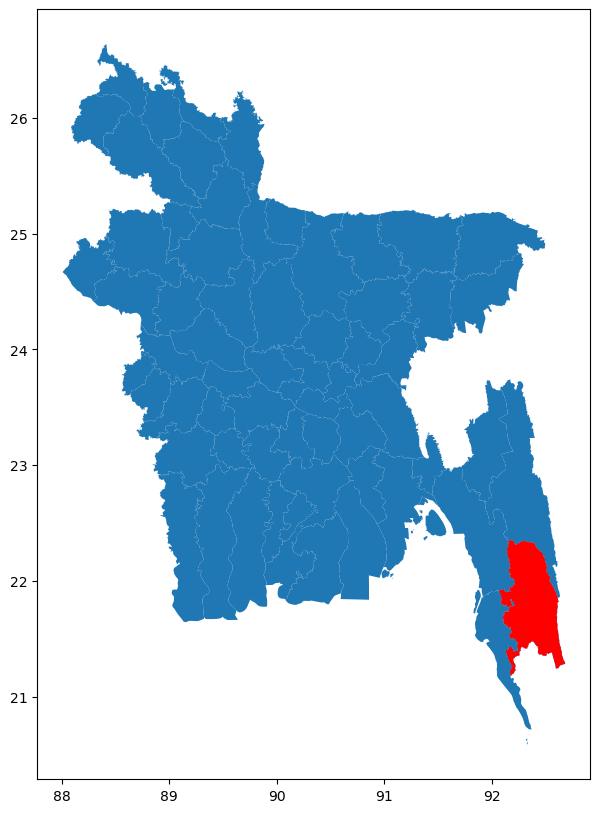

In [17]:
# example - showing the selection of a single districts


dist1 = districts[districts['DISTRICT_N'] == 'Bandarban'].copy()
# dist1 = dist1.to_crs('epsg:4326')
ax = districts.plot(figsize=(12, 10))
dist1.plot(ax=ax, color='red')

#### cliiping the region in netcdf file

(20.0, 27.0)

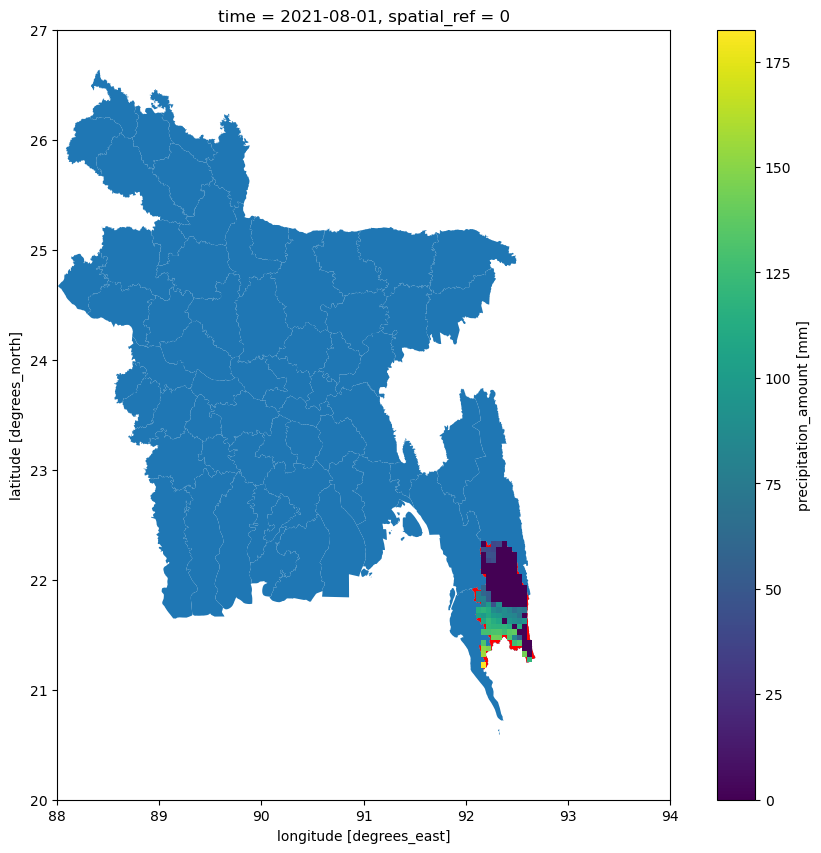

In [20]:
# plot all the districts
ax = districts.plot(figsize=(12, 10))
# plot the selected district
dist1.plot(ax=ax, color='red')

# clipping the selceted district to mask/select the data and plot the data
ds.rio.clip(dist1.geometry.apply(
    mapping), dist1.crs).precipitation_amount.sel(time='2021-08-01').plot(ax=ax)

ax.set_xlim([88, 94])
ax.set_ylim([20, 27])

### get the data for each districts

In [26]:
# create unique names from the shape file
district_names = districts.DISTRICT_N.unique()
# # create a dataframe for daily time series data
df_rain_dist = pd.DataFrame()

# #  First clip the region of interest here -district using rioxarray package
# # Then populate the dataframe with mean values within each district
for district in district_names:
    dist = districts[districts['DISTRICT_N'] == district].copy()
    df_rain_dist[district] = ds.rio.clip(dist.geometry.apply(
        mapping), dist.crs).mean(['longitude', 'latitude']).precipitation_amount.values

df_rain_dist.insert(0, 'date', ds.time.values)
df_rain_dist.head()

,date,Bandarban,Brahmanbaria,Chandpur,Chattogram,Cox's Bazar,Cumilla,Feni,Khagrachhari,Lakshmipur,...,Kurigram,Lalmonirhat,Nilphamari,Panchagarh,Rangpur,Thakurgaon,Habiganj,Moulvibazar,Sunamganj,Sylhet
0,1981-01-01,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.082209,0.370649,0.000000,0.0
1,1981-01-02,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
2,1981-01-03,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.203110,0.000000,0.043555,0.0
3,1981-01-04,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,2.75609,1.504622,0.041465,0.0,0.562782,0.0,0.000000,0.000000,0.224349,0.0
4,1981-01-05,0.920377,0.0,0.922465,1.714097,1.059871,0.623037,4.697962,4.926849,4.55919,...,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0


### extract data for the each cities mentioned in the discussion

In [41]:
# getting the cordinates of the cities using geocoder -Nomonatim

from geopy.geocoders import Nominatim
city_list = [
    "Chittagong",
    "Barisal",
    'Bogra',
    "Comilla",
    "Khulna",
    "Mymensigh",
    "Narayanganj Bangladesh",
    "Rajshahi",
    "Dhaka",
    "Sylhet"
]
place_df = pd.DataFrame({'city': city_list})


geolocator = Nominatim(user_agent="notebook")

for index, row in place_df.iterrows():
    try:
        # place_df.loc[index,'Country'] = geolocator.geocode(row[0]).address.split(',')[-1].strip()
        place_df.loc[index, 'Latitude'] = geolocator.geocode(
            row.city).point.latitude
        place_df.loc[index, 'Longitude'] = geolocator.geocode(
            row.city).point.longitude
    except Exception as e:
        print(e)

place_df.loc[place_df['city'] ==
             'Narayanganj Bangladesh', 'city'] = 'Narayanganj'

place_df

,city,Latitude,Longitude
0,Chittagong,22.333778,91.834435
1,Barisal,22.493403,90.354801
2,Bogra,24.850066,89.372843
3,Comilla,23.461061,91.180875
4,Khulna,22.937209,89.285274
5,Mymensigh,23.855938,90.404172
6,Narayanganj,23.623673,90.498807
7,Rajshahi,24.371551,88.592104
8,Dhaka,23.764402,90.389015
9,Sylhet,24.735885,91.685248


In [45]:
# # create a dataframe for daily time series data

df_rain_city = pd.DataFrame()


# # Then populate the dataframe with mean values in each city

for index, row in place_df.iterrows():
    df_rain_city[row.city] = ds.precipitation_amount.sel(
        latitude=row.Latitude, longitude=row.Longitude, method='nearest').values
    place_df.loc[index, 'new_lat'] = ds.precipitation_amount.sel(
        latitude=row.Latitude, longitude=row.Longitude, method='nearest').latitude.values
    place_df.loc[index, 'new_lon'] = ds.precipitation_amount.sel(
        latitude=row.Latitude, longitude=row.Longitude, method='nearest').longitude.values


df_rain_city.insert(0, 'date', ds.time.values)
df_rain_city['date'] = pd.to_datetime(df_rain_city['date'])
df_rain_city.head()

,date,Chittagong,Barisal,Bogra,Comilla,Khulna,Mymensigh,Narayanganj,Rajshahi,Dhaka,Sylhet
0,1981-01-01,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1981-01-02,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1981-01-03,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1981-01-04,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1981-01-05,0.0,4.932116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:

df_rain_city.dtypes

date           datetime64[ns]
Chittagong            float32
Barisal               float32
Bogra                 float32
Comilla               float32
Khulna                float32
Mymensigh             float32
Narayanganj           float32
Rajshahi              float32
Dhaka                 float32
Sylhet                float32
dtype: object

## visualization of time series

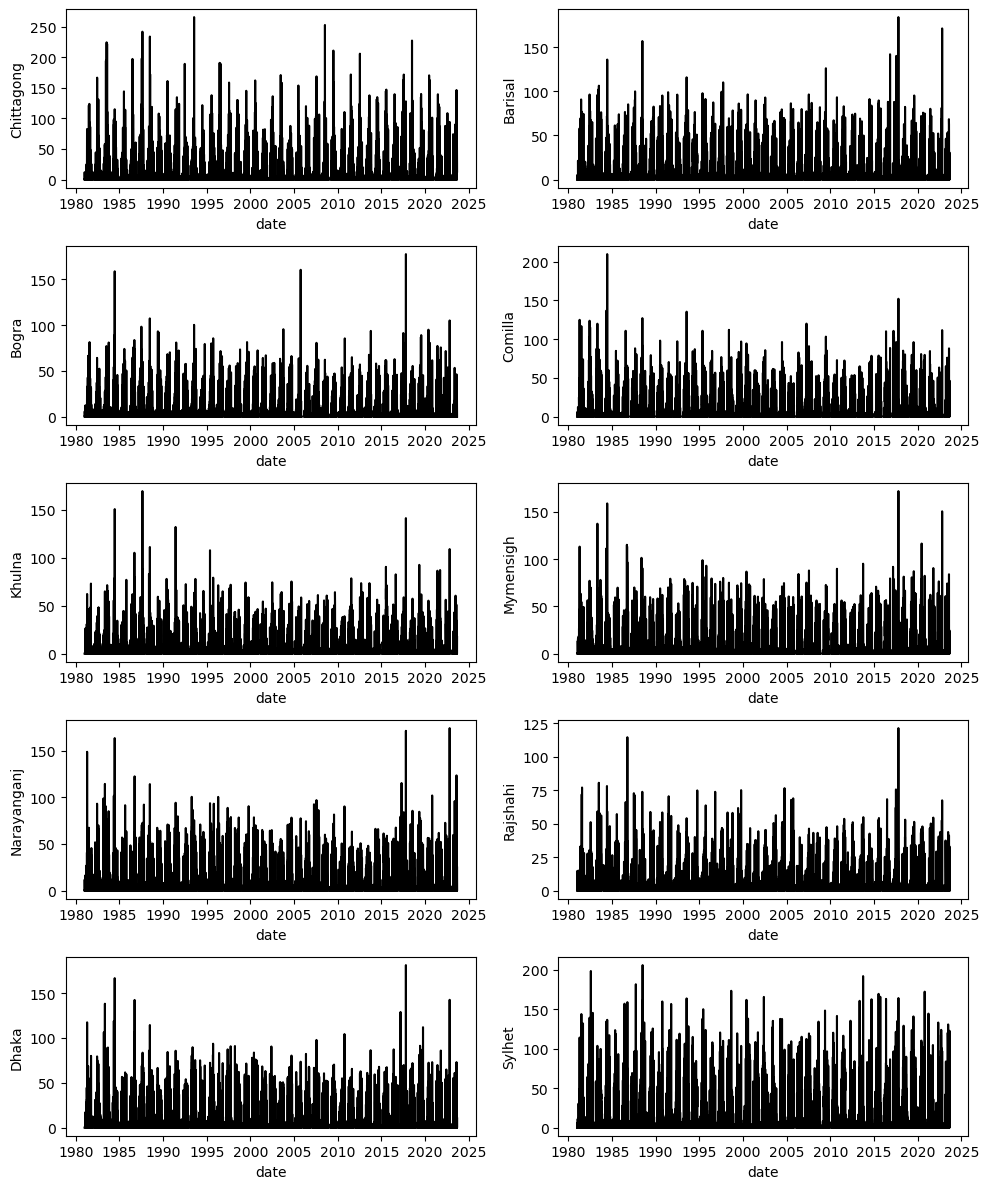

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 12))
axs = axs.reshape(-1)
for index, column in enumerate(df_rain_city.columns[1:]):
    sns.lineplot(data=df_rain_city, x='date',
                 y=column, ax=axs[index], color='k')

plt.tight_layout()

In [44]:
# calculate the distance between city and the cordinates we have extraced from the netcdf file

def calculate_distance(row):
    coords1 = (row['Latitude'], row['Longitude'])
    coords2 = (row['new_lat'], row['new_lon'])
    return geodesic(coords1, coords2).kilometers


place_df['distance (km)'] = place_df.apply(calculate_distance, axis=1)
place_df

,city,Latitude,Longitude,new_lat,new_lon,distance (km)
0,Chittagong,22.333778,91.834435,22.325,91.825004,1.374368
1,Barisal,22.493403,90.354801,22.475,90.375004,2.911297
2,Bogra,24.850066,89.372843,24.875,89.375004,2.770517
3,Comilla,23.461061,91.180875,23.475,91.175004,1.656084
4,Khulna,22.937209,89.285274,22.925,89.275004,1.714018
5,Mymensigh,23.855938,90.404172,23.875,90.425004,2.993232
6,Narayanganj,23.623673,90.498807,23.625,90.475004,2.433462
7,Rajshahi,24.371551,88.592104,24.375,88.575004,1.776426
8,Dhaka,23.764402,90.389015,23.775,90.375004,1.848564
9,Sylhet,24.735885,91.685248,24.725,91.675004,1.589953


# saving data

In [101]:

# save df_rain_city
df_rain_city.to_csv(
    'Omdena/data/csv/daily_rainfall_cities_1981_2023.csv',  index=False)


#  save df_rain_district

df_rain_dist.to_csv(
    '/Omdena/data/csv/daily_mean_rainfall_districts_after_2000.csv', index=False)